### Prepare base u-net model

In [1]:
import os
from pathlib import Path

import yaml
from box import ConfigBox


WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

DATA_ROOT_PATH = "data"


Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


In [2]:
# Configs
def read_yaml(path_to_yaml: Path) -> ConfigBox:
    with open(path_to_yaml, 'r') as yaml_file:
        content = yaml.safe_load(yaml_file)
    return ConfigBox(content)

config = read_yaml(Path('config/config.yaml'))
config.prepare_base_model.base_model_path

'artifacts/prepare_base_model/base_model.h5'

In [3]:
import torch
import segmentation_models_pytorch as smp

# Define the U-Net model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained weights
    in_channels=3,                  # Input channels (greyscale)
    classes=3,                      # Output classes (1 for binary segmentation)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Print model summary
print(model)

/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
import cv2

# Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        if image_list:
            self.image_list = image_list
        else:
            self.image_list = glob.glob(os.path.join(image_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx])  # Assuming masks have the same name

        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
        else:
            image = cv2.imread(img_path)
            if image is None:
                print(f"OpenCV could not read: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB


        if not os.path.exists(mask_path):
            print(f"File not found: {mask_path}")
        else:
            mask = cv2.imread(mask_path)
            if mask is None:
                print(f"OpenCV could not read: {mask_path}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Normalize & Convert to tensors
        image = image / 255.0  # Normalize
        mask = mask / 255.0  # Normalize (Assuming mask values are 0 or 255)
        # mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return image, mask

# Define dataset and dataloaders
with open("data/metadata/training.txt", "r") as f:
    image_list_train = f.read().splitlines()

train_dataset = SegmentationDataset(
    "data/norm_images",
    "data/boundary_labels",
    image_list_train,
)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)


In [5]:
import torch.optim as optim

# Loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
import torch.nn.functional as F

def pad_images(images, target_height=544, target_width=704):
    height, width = images.shape[-2], images.shape[-1]
    pad_height = target_height - height
    pad_width = target_width - width
    padding = (0, pad_width, 0, pad_height, 0, 0)  # (left, right, top, bottom)
    return F.pad(images, padding, mode='constant', value=0)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(model, dataset, idx=0, save_path=None, if_show=True):
    model.eval()  # Set to evaluation mode
    image, mask = dataset[idx]

    # Pad images to match the target size
    image = pad_images(image)

    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred = model(image).squeeze().permute(1, 2, 0).cpu().numpy()

    pred = (pred > 0).astype(np.uint8)  # Convert logits to binary mask

    # Plot images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Image")
    ax[1].imshow(mask.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[1].set_title("Ground Truth")
    ax[2].imshow(pred * 255)
    ax[2].set_title("Prediction")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    if if_show:
        plt.show()
    else:
        plt.close()

In [8]:
from tqdm import tqdm
import psutil
from datetime import datetime

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # Pad images to match the target size
            images = pad_images(images)
            masks = pad_images(masks)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
            
            # Get CPU & RAM usage
            ram_used = psutil.virtual_memory().used / 1024**3

            progress_bar.set_postfix(loss=loss.item(), ram_used=f"{ram_used:.2f} GB", cpu_usage=f"{psutil.cpu_percent()}%")

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        visualize_sample(model, train_dataset, idx=2, save_path=f"figures/prediction_epoch_{epoch+1}_{timestamp}.png", if_show=False)


# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"models/unet_resnet34_{timestamp}.pth")  # Save model weights
print("Model saved successfully!")


Epoch 1/10: 100%|██████████| 5/5 [03:47<00:00, 45.53s/it, cpu_usage=81.8%, loss=0.481, ram_used=5.63 GB]


Epoch 1/10, Loss: 0.5836


Epoch 2/10: 100%|██████████| 5/5 [03:44<00:00, 44.98s/it, cpu_usage=81.1%, loss=0.503, ram_used=5.78 GB]


Epoch 2/10, Loss: 2.2533


Epoch 3/10: 100%|██████████| 5/5 [03:35<00:00, 43.01s/it, cpu_usage=79.6%, loss=0.584, ram_used=6.29 GB]


Epoch 3/10, Loss: 0.7410


Epoch 4/10: 100%|██████████| 5/5 [03:34<00:00, 42.97s/it, cpu_usage=79.4%, loss=0.514, ram_used=5.68 GB]


Epoch 4/10, Loss: 0.6316


Epoch 5/10: 100%|██████████| 5/5 [03:37<00:00, 43.48s/it, cpu_usage=80.0%, loss=0.409, ram_used=5.44 GB]


Epoch 5/10, Loss: 0.4433


Epoch 6/10: 100%|██████████| 5/5 [03:36<00:00, 43.35s/it, cpu_usage=79.5%, loss=0.402, ram_used=5.92 GB]


Epoch 6/10, Loss: 0.4041


Epoch 7/10: 100%|██████████| 5/5 [03:33<00:00, 42.79s/it, cpu_usage=79.5%, loss=0.418, ram_used=5.78 GB]


Epoch 7/10, Loss: 0.4055


Epoch 8/10: 100%|██████████| 5/5 [03:35<00:00, 43.16s/it, cpu_usage=80.0%, loss=0.393, ram_used=6.23 GB]


Epoch 8/10, Loss: 0.3885


Epoch 9/10: 100%|██████████| 5/5 [03:37<00:00, 43.48s/it, cpu_usage=80.0%, loss=0.384, ram_used=5.56 GB]


Epoch 9/10, Loss: 0.3946


Epoch 10/10: 100%|██████████| 5/5 [03:36<00:00, 43.21s/it, cpu_usage=79.9%, loss=0.364, ram_used=5.80 GB]


Epoch 10/10, Loss: 0.3659
Model saved successfully!


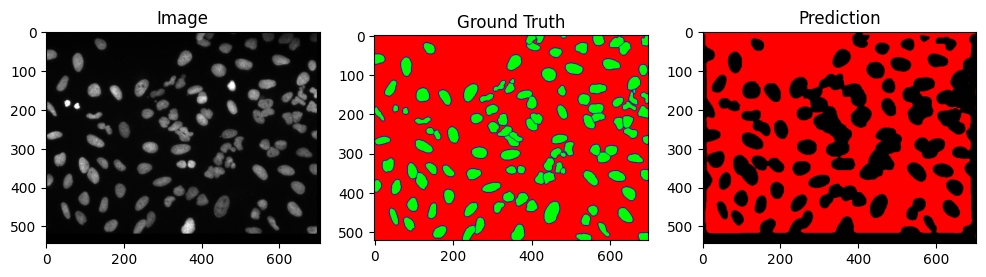

In [9]:
# Visualize prediction
visualize_sample(model, train_dataset, idx=2)
